# Initialize

In [1]:
from ops.imports_ipython import *
import glob

In [2]:
os.chdir('20200202_6W-LaC024F/')

# combine tables

In [4]:
ops.utils.combine_tables('cp_phenotype',output_filetype='hdf',subdir='process_ph/tables',n_jobs=-2,
    usecols=[
        'well','tile','cell',
        'i','j','bounds_0','bounds_1','bounds_2','bounds_3',
        # to identify cells on an acquisition border
        'cell_dapi_min','cell_tubulin_min','cell_gh2ax_min','cell_phalloidin_min'
        ]
)
os.rename('cp_phenotype.hdf','min_cp_phenotype.hdf')

In [5]:
ops.utils.combine_tables('merge',output_filetype='hdf',subdir='alignment',n_jobs=-2)

In [6]:
ops.utils.combine_tables('cells',output_filetype='hdf',subdir='process_sbs/tables',n_jobs=-2)

In [6]:
df_merged = pd.read_hdf('merge.hdf')

# add distance to FOV center for each cell

In [7]:
def fov_distance(df,i='i',j='j',dimensions=(2960,2960),suffix=''):
    distance  = lambda x: np.sqrt((x[i]-(dimensions[0]/2))**2+(x[j]-(dimensions[1]/2))**2)
    df['fov_distance'+suffix]=df.apply(distance,axis=1)
    return df

In [8]:
df_merged.pipe(fov_distance,i='i_0',j='j_0',suffix='_0');

In [9]:
df_merged.pipe(fov_distance,i='i_1',j='j_1',dimensions=(1480,1480),suffix='_1');

In [10]:
df_merged.sort_values(['fov_distance_1']).head()

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1
379,B3,586,413,1071.566453,1019.805259,173,2406,740.134021,740.288660,0.780286,615.302496,0.318255
298,A3,770,317,1060.772009,1024.415350,205,1813,739.808333,739.716667,0.425530,619.119925,0.342073
468,A3,857,485,1061.561268,1027.695070,235,2958,739.630435,739.847826,0.713498,616.174263,0.399669
507,B3,1242,542,1077.040024,1024.028674,327,3202,740.554545,739.900000,0.763799,608.511785,0.563490
415,A3,1058,447,1063.876896,1025.654609,284,2579,740.070796,740.663717,0.451531,616.107273,0.667482


# add mapping info

In [11]:
df_cells = pd.read_hdf('cells.hdf')

In [12]:
df_cells.head()

,cell,tile,well,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,...,cell_barcode_count_0,cell_barcode_1,cell_barcode_count_1,barcode_count,sgRNA_0,gene_symbol_0,group_0,sgRNA_1,gene_symbol_1,group_1
0,20,166,B3,0.698522,0.743612,0.232124,0.895611,0.798273,1.000000,0.863210,...,2,AGGTAGAATAC,1.0,4,GCTGTAATTAATCATATGTG,AMY1B&AMY1C,essentials_11L2,AGGTAGAATACAAACAACTG,SEC23IP,essentials_11L2
1,24,166,B3,0.525437,0.347310,0.280394,1.000000,0.318070,0.542979,0.363451,...,1,NaN,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,25,166,B3,0.731803,0.454607,0.945970,0.116529,0.324889,0.692522,1.000000,...,4,NaN,0.0,4,GCTGTAATTAATCATATGTG,AMY1B&AMY1C,essentials_11L2,NaN,NaN,NaN
3,26,166,B3,0.843078,0.856242,0.720628,0.638370,1.000000,0.727202,0.970114,...,3,NaN,0.0,3,TCGAACATGCTGTGGAGTCA,YAP1,essentials_11L2,NaN,NaN,NaN
4,27,166,B3,0.922944,0.572413,0.406026,0.482363,0.972538,0.486850,0.658450,...,4,NaN,0.0,4,TATACGAACTAACCTCCATG,NIPBL,essentials_11L2,NaN,NaN,NaN


In [15]:
df_cells['mapped_single_gene'] = (df_cells.apply(lambda x: True 
                    if (pd.notnull(x.gene_symbol_0)&pd.isnull(x.gene_symbol_1))|(x.gene_symbol_0==x.gene_symbol_1) 
                    else False,axis=1)
                                  )

In [16]:
df_cells.mapped_single_gene.value_counts()

True     5808188
False    2646904
Name: mapped_single_gene, dtype: int64

In [17]:
df_merged = df_merged.merge((df_cells[['well','tile','cell','sgRNA_0','gene_symbol_0','group_0','mapped_single_gene']]
                             .rename({'tile':'site','cell':'cell_1'},axis=1)),
                            how='left',on=['well','site','cell_1'])

In [18]:
df_merged.head(10).sort_values(['mapped_single_gene','fov_distance_1'],ascending=[False,True])

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1,sgRNA_0,gene_symbol_0,group_0,mapped_single_gene
2,B3,474,11,29.213634,517.027912,123,1294,476.328125,1247.937500,1.543276,1741.291567,572.296568,GCCAATCGGATTGTAGAAAT,nontargeting,essentials_11L2,True
8,B3,474,29,84.411159,627.540087,123,1313,490.376068,1275.572650,1.617055,1635.345871,590.889305,GAAGAGCCAGCTCCTGAAGG,C19orf54,essentials_11L2,True
6,B3,474,25,73.067734,713.118842,123,1310,487.173077,1297.057692,1.297805,1602.362353,611.747273,GAAGAGCCAGCTCCTGAAGG,C19orf54,essentials_11L2,True
0,B3,474,7,17.661795,721.333507,123,1286,473.375940,1299.330827,1.501462,1647.424618,619.628408,CAGGCTACAACTGACGAGGA,ANKRD36B,essentials_11L2,True
9,B3,474,30,87.563015,983.984167,123,1314,490.295652,1364.973913,0.811559,1478.144940,673.011629,AGCACAAGTATATTATATTG,PPM1D,essentials_11L2,True
3,B3,474,12,37.197802,988.006689,123,1295,477.387755,1366.095238,0.833779,1524.380399,678.940674,AGCACAAGTATATTATATTG,PPM1D,essentials_11L2,True
1,B3,474,8,19.623977,1052.589474,123,1287,472.900662,1383.264901,1.773600,1521.636582,696.514026,AGCACAAGTATATTATATTG,PPM1D,essentials_11L2,True
5,B3,474,23,69.770261,1164.680509,123,1308,485.527778,1410.203704,0.537361,1445.051659,716.888496,ATTCAGGTAAAAGCCCCGTG,CLUH,essentials_11L2,True
4,B3,474,17,52.785990,1227.765424,123,1301,480.550000,1427.100000,1.733828,1449.331609,734.452662,ATTCAGGTAAAAGCCCCGTG,CLUH,essentials_11L2,True
7,B3,474,26,77.444985,1325.932523,123,1312,487.175926,1451.166667,1.017470,1410.991622,754.770190,ATTCAGGTAAAAGCCCCGTG,CLUH,essentials_11L2,True


# add phenotype min info

In [19]:
df_phenotype = pd.read_hdf('min_cp_phenotype.hdf').fillna(0)

In [20]:
min_cols = [col for col in df_phenotype.columns if '_min' in col]
info_cols = [col for col in df_phenotype.columns if col not in min_cols]

In [22]:
df_phenotype['channels_min'] = df_phenotype[min_cols].apply(lambda x: x.min(axis=0),axis=1)

In [24]:
df_merged = df_merged.merge((df_phenotype[['well','tile','cell','channels_min']]
                             .rename(columns={'cell':'cell_0'})),
                            how='left',on=['well','tile','cell_0'])

In [27]:
misaligned = np.array([['B2',892],['B1',284]])
misaligned_wells = list(misaligned[:,0])
misaligned_tiles = list(misaligned[:,1])

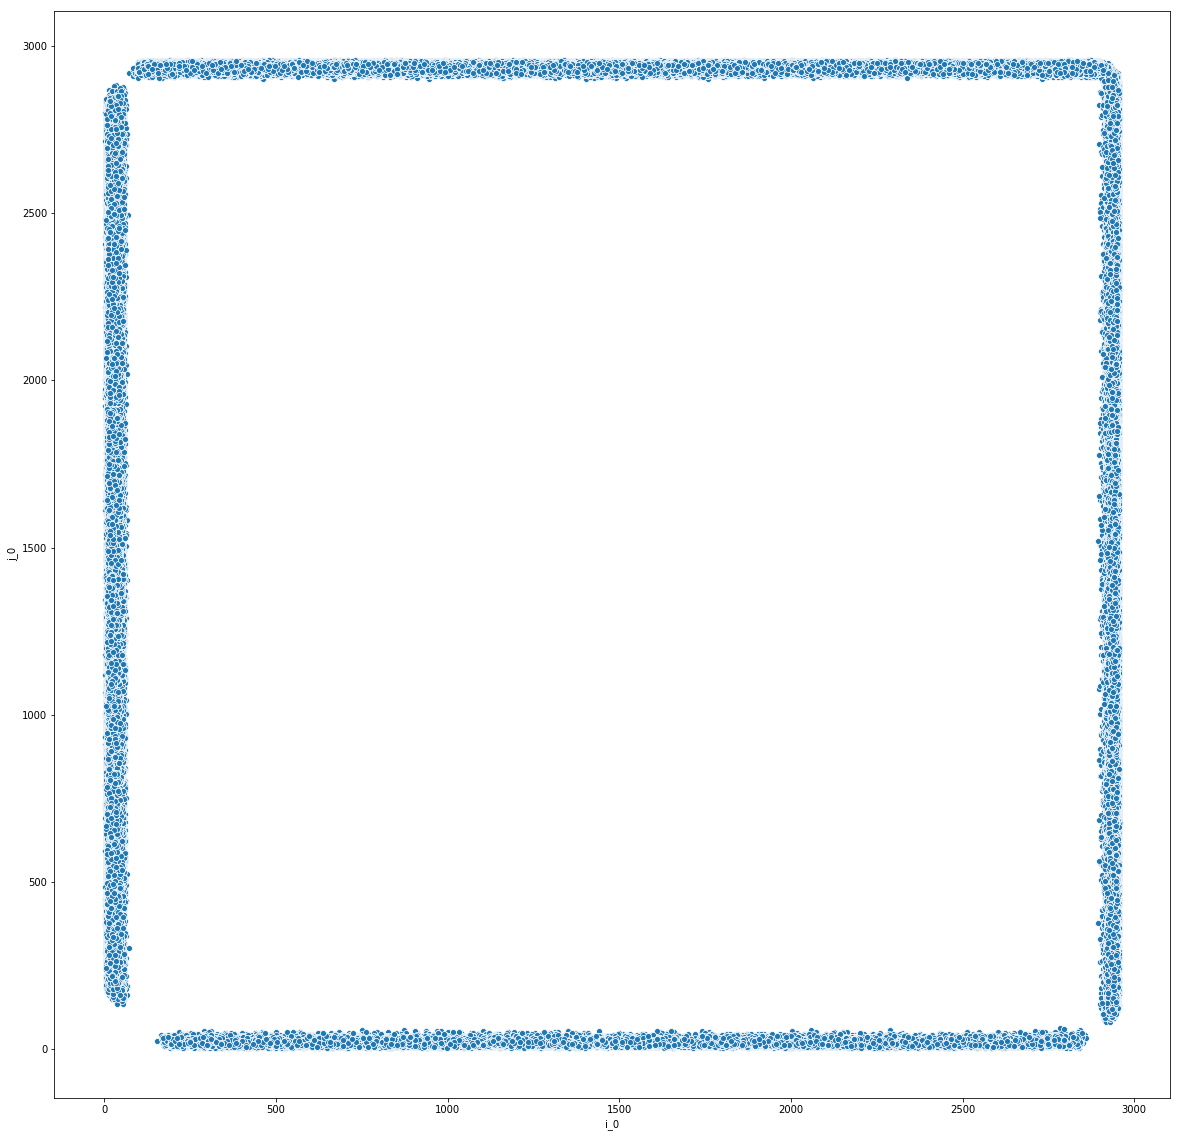

In [30]:
# visualize cells overlapping channel alignment edges
# (only relevant if phenotype channels are acquired separately)
plt.figure(figsize=(20,20))
sns.scatterplot(data=(df_merged
                      .query('channels_min==0')
                      # identified by manual exploration
                      .query('well != @misaligned_wells[0] | tile != @misaligned_tiles[0]') 
                      .query('well != @misaligned_wells[1] | tile != @misaligned_tiles[1]')
                      [['i_0','j_0']]
                     ),
                x='i_0',y='j_0')

# filter merged datasets for duplicates

In [31]:
df_merged.groupby(['well','tile']).cell_0.value_counts().value_counts()

1    6819679
2    1814910
3      36627
4       2732
Name: cell_0, dtype: int64

In [32]:
df_merged.groupby(['well','site']).cell_1.value_counts().value_counts()

1    6478192
2    1869825
3      61874
4      41711
Name: cell_1, dtype: int64

In [33]:
df_merged.drop_duplicates(['well','site','cell_1']).pipe(len)

8451602

In [34]:
df_merged.pipe(len)

10570308

In [38]:
# remove cells with phenotype channel min ==0
df_merged_ph = (df_merged
             .query('well != @misaligned_wells[0] | tile != @misaligned_tiles[0]') 
             .query('well != @misaligned_wells[1] | tile != @misaligned_tiles[1]')
             .query('channels_min>0')
            )

In [39]:
df_merged_ph.drop_duplicates(['well','site','cell_1']).pipe(len)

8424926

In [41]:
df_merged_ph.groupby(['well','site']).cell_1.value_counts().value_counts()

1    6729348
2    1622639
3      41530
4      31409
Name: cell_1, dtype: int64

In [42]:
# drop sbs cells mapping to same phenotype cell by priority (mapping, fov_distance)
df_merged_filt = (df_merged_ph
                  .sort_values(['mapped_single_gene','fov_distance_1'],
                               ascending=[False,True])
                  .drop_duplicates(['well','tile','cell_0'],keep='first')
                 )

In [19]:
df_merged_filt.groupby(['well','site']).cell_1.value_counts().value_counts()

1    4724187
2    1160655
3      32308
4      27636
Name: cell_1, dtype: int64

In [43]:
# drop duplicated phenotype cells mapping to same sbs cell by priority (fov_distance)
df_merged_filt_filt = (df_merged_filt
                       .sort_values(['fov_distance_0'],ascending=True)
                       .drop_duplicates(['well','site','cell_1'],keep='first')
                      )

In [44]:
df_merged_filt_filt.pipe(len)

6772126

In [45]:
df_merged_filt_filt[df_merged_filt_filt.mapped_single_gene==True].pipe(len)

4248584

In [ ]:
df_merged.to_hdf('merge.20200501.hdf', 'x', mode='w')

In [ ]:
df_merged_filt_filt.to_hdf('merged_deduped.20200501.hdf', 'x', mode='w')

# check cell matching rate

In [49]:
df_merged_filt_filt.well.value_counts()

B2    1277061
A2    1215984
A1    1076462
B1    1072876
A3    1065218
B3    1064525
Name: well, dtype: int64

In [31]:
df_sbs_info = pd.concat([pd.read_hdf(f) for f in glob.glob('sbs_info_*.hdf')])

In [32]:
df_sbs_info.to_hdf('sbs_info.hdf','x',mode='w')

In [52]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_1','tile':'site'}

#before deduping, how many sbs cells map to a phenotype cell
df_sbs_matching = (df_sbs_info
                   .rename(columns=cols_1)
                   .drop(columns=['i','j'])
                   .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','site','cell_1'])
                  )

In [53]:
# before deduping
for well,df in df_sbs_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 87.0727050643232%
For well A2, cell matching rate is 85.36655379940801%
For well A3, cell matching rate is 86.02184646999889%
For well B1, cell matching rate is 86.45142762149206%
For well B2, cell matching rate is 85.903307932587%
For well B3, cell matching rate is 85.31318342659667%


In [54]:
del df_sbs_matching

In [55]:
del df_sbs_info

In [37]:
df_ph_info = pd.concat([pd.read_hdf(f) for f in glob.glob('ph_info_*.hdf')])

In [38]:
df_ph_info.to_hdf('ph_info.hdf','x',mode='w')

In [57]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_0'}

#before deduping, how many sbs cells map to a phenotype cell
df_ph_matching = (df_ph_info
                 .rename(columns=cols_1)
                 .drop(columns=['i','j'])
                 .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','tile','cell_0'])
                )

In [58]:
for well,df in df_ph_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 89.74479251573683%
For well A2, cell matching rate is 89.13150125235921%
For well A3, cell matching rate is 89.17230307627906%
For well B1, cell matching rate is 88.34817514370636%
For well B2, cell matching rate is 88.51301593028106%
For well B3, cell matching rate is 88.1212307505119%
